In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random as rd


import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Lambda, Input, Dense
from tensorflow.keras.losses import mse, binary_crossentropy, kl_divergence
from tensorflow.keras import optimizers
from keras.utils.vis_utils import plot_model
from tensorflow.keras import backend as K

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
#Function to read data from file
def get_data(din):
    bf = pd.read_csv(din,sep='\t')
    genes = bf['Hugo_Symbol']
    cols = list(bf.columns)
    cols.remove('Entrez_Gene_Id')
    cols.remove('Hugo_Symbol')
    bf = bf[cols]
    bf = bf.transpose()
    bf.columns = genes
    return bf

def getDataset(din1, din2, din3):
    normal1 = get_data(din1)
    normal2 = get_data(din2)
    abnormal = get_data(din3)
    common_gene = set(list(normal1.columns)).intersection(set(list(normal2.columns))).intersection(set(list(abnormal.columns)))
    common_gene = list(common_gene)
    normal1 = normal1[common_gene]
    normal2 = normal2[common_gene]
    abnormal = abnormal[common_gene]
    #abnormal = list(abnormal)
    
    X_train = pd.concat( [normal1, normal2] ).values
    
    abnormal = abnormal.values.tolist()
    normal1 = normal1.values.tolist()
    
    abnormal = list(np.float_(abnormal))
    normal1 = list(np.float_(normal1))
    
    abnormal = rd.SystemRandom().sample(abnormal, 47)
    normal1 = rd.SystemRandom().sample(normal1, 112)
    
    abnormal = pd.DataFrame(abnormal)
    normal1 = pd.DataFrame(normal1)
    
    #X_train = np.random.shuffle(X_train) 
    X_test = pd.concat( [normal1, abnormal] ).values
    y_test = np.zeros(len(X_test), dtype=int)
    y_test[len(normal1):] = 1
    

    
    X_train = np.asarray(X_train)
    X_test = np.asarray(X_test)
    y_test = np.asarray(y_test)
                

    return X_train, X_test, y_test

In [3]:
# Code to visualize the results

class Visualization:
    labels = ["Normal","Anomal"]
    
    def draw_confusion_matrix(self, y, y_pred):
        matrix = confusion_matrix(y, y_pred)
        
        plt.figure(figsize=(10,8))
        colors = ["orange","green"]
        sns.heatmap(matrix, xticklabels=self.labels, yticklabels=self.labels, cmap=colors, annot=True, fmt="d")
        plt.title("Confusion Matrix")
        plt.ylabel("Actual")
        plt.xlabel("Predicted")
        plt.show()
        
    def draw_anomaly(self, y, error, treshold):
        groupsDF = pd.DataFrame({'error':error,'true':y}).groupby('true')
        
        figure,axes = plt.subplots(figsize=(12,8))
        
        for name, group in groupsDF:
            axes.plot(group.index, group.error, marker='x' if name == 1 else 'o', linestyle='',
                     color='r' if name ==1 else 'g', label="Anomaly" if name == 1 else "Normal")
            
        axes.hlines(treshold, axes.get_xlim()[0], axes.get_xlim()[1], colors='b', zorder = 100, label = 'Treshold')
        axes.legend()
            
        plt.title("Anomalies")
        plt.ylabel("Error")
        plt.xlabel("Data")
        plt.show()
        
    def draw_error(self, error, treshold):
        plt.plot(error, marker='o', ms=3.5, linestyle='', label='Point')
        
        plt.hlines(treshold, xmin=0, xmax=len(error)-1, colors="b", zorder=100, label='Treshold')
        plt.legend()
        plt.title("Reconstruction error")
        plt.ylabel("Error")
        plt.xlabel("Data")
        plt.show()
    

In [4]:
din1 = 'data/thyroid-rsem-fpkm-gtex.txt'
din2 = 'data/thca-rsem-fpkm-tcga.txt'
din3 = 'data/thca-rsem-fpkm-tcga-t.txt'

X_train, X_test, y_test = getDataset(din1, din2, din3)


In [5]:
from numpy import savetxt

savetxt('dataset/x_train_thca.csv', X_train, delimiter='\t')
savetxt('dataset/x_test_thca.csv', X_test, delimiter='\t')
savetxt('dataset/y_test_thca.csv', y_test, delimiter='\t')



In [6]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)


In [7]:
print(X_test)

[[0.04296537 0.62774946 0.         ... 0.57400883 0.39456086 0.06962208]
 [0.08030303 0.57585605 0.         ... 0.34714435 0.17654926 0.05567599]
 [0.14249639 0.39588821 0.         ... 0.5255297  0.22024075 0.00603367]
 ...
 [0.36374459 0.25481476 0.         ... 0.42589193 0.19393669 0.30374305]
 [0.27287157 0.21215749 0.         ... 0.21356622 0.23316986 0.19054845]
 [0.         0.09598741 0.         ... 0.37081328 0.10967454 0.10589638]]


In [8]:
X_train.shape

(371, 19239)

In [9]:
X_test.shape

(159, 19239)

In [10]:
print(y_test)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1]


In [11]:
def get_error_term(v1, v2, _rmse=True):
    if _rmse:
        return np.sqrt(np.mean((v1 - v2) ** 2, axis=1))
    #return MAE
    return np.mean(abs(v1 - v2), axis=1)

In [12]:
# The reparameterization trick

def sample(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [13]:
original_dim = X_train.shape[1]
input_shape = (original_dim,)
intermediate_dim = int(original_dim / 2)
latent_dim = int(original_dim / 3)

In [14]:
# encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# sampling 
z = Lambda(sample, output_shape=(latent_dim,), name='z')([z_mean, z_log_var]) 

# instantiate encoder model
encoder = Model(inputs, z, name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 19239)]      0           []                               
                                                                                                  
 dense (Dense)                  (None, 9619)         185069560   ['encoder_input[0][0]']          
                                                                                                  
 z_mean (Dense)                 (None, 6413)         61693060    ['dense[0][0]']                  
                                                                                                  
 z_log_var (Dense)              (None, 6413)         61693060    ['dense[0][0]']                  
                                                                                            

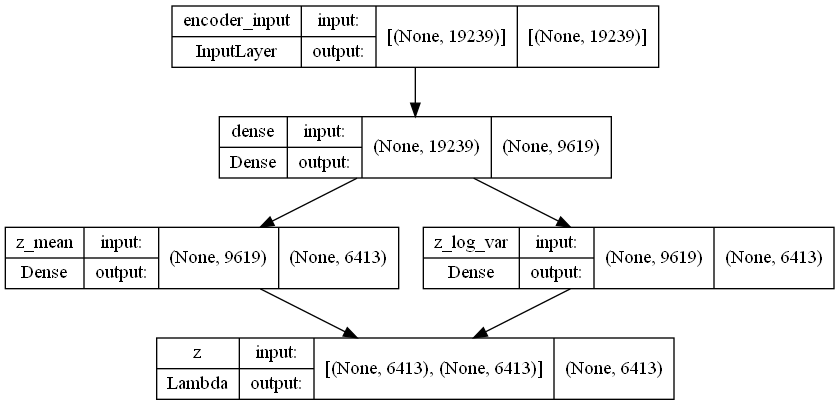

In [15]:
plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

In [16]:
# decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)
# Instantiate the decoder model:
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 6413)]            0         
                                                                 
 dense_1 (Dense)             (None, 9619)              61696266  
                                                                 
 dense_2 (Dense)             (None, 19239)             185079180 
                                                                 
Total params: 246,775,446
Trainable params: 246,775,446
Non-trainable params: 0
_________________________________________________________________


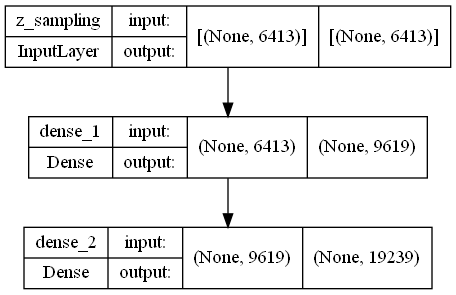

In [17]:
plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

In [18]:
# full VAE model
outputs = decoder(encoder(inputs))
vae_model = Model(inputs, outputs, name='vae_mlp')

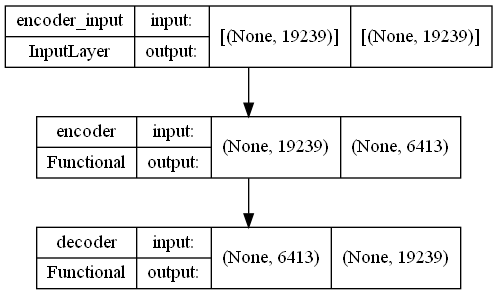

In [19]:
plot_model(vae_model, to_file='vae_mlp_model.png', show_shapes=True)

In [20]:
# the KL loss function:
def vae_loss(x, x_decoded_mean):
    # compute the average MSE error, then scale it up, ie. simply sum on all axes
    reconstruction_loss = K.sum(K.square(x - x_decoded_mean))
    # compute the KL loss
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.square(K.exp(z_log_var)), axis=-1)
    # return the average loss over all 
    total_loss = K.mean(reconstruction_loss + kl_loss)    
    #total_loss = reconstruction_loss + kl_loss
    return total_loss

In [21]:
#opt = optimizers.Adam(learning_rate=0.01)


epochs = 200
learning_rate = 0.0001
decay_rate = learning_rate / epochs
#opt = optimizers.RMSprop(learning_rate=learning_rate, decay=decay_rate)
opt = optimizers.Adam(learning_rate=learning_rate, decay=decay_rate)
vae_model.compile(optimizer=opt, loss=vae_loss)

#vae_model.compile(optimizer='adam',
#                  loss=vae_loss)

vae_model.summary()

Model: "vae_mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 19239)]           0         
                                                                 
 encoder (Functional)        (None, 6413)              308455680 
                                                                 
 decoder (Functional)        (None, 19239)             246775446 
                                                                 
Total params: 555,231,126
Trainable params: 555,231,126
Non-trainable params: 0
_________________________________________________________________


In [22]:
# Learning
# Finally, we train the model:
history = vae_model.fit(X_train, X_train, 
                        shuffle=True, 
                        epochs=epochs, 
                        batch_size=256, 
                        validation_data=(X_test, X_test))
#history = vae_model.fit(X_train, X_train,
#                        shuffle=True,
#                        epochs=10,
#                        batch_size=256)

vae_model.save_weights('vae_thyroid.h5')

Train on 371 samples, validate on 159 samples
Epoch 1/200
371/371 [==============================] - ETA: 0s - loss: 482406.2079 

C:\Users\Innocent SADO\Anaconda3\envs\Master2\lib\site-packages\keras\engine\training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


371/371 [==============================] - 138s 372ms/sample - loss: 482406.2079 - val_loss: 179071.2031
Epoch 2/200
371/371 [==============================] - 100s 268ms/sample - loss: 200596.8083 - val_loss: 171253.3594
Epoch 3/200
371/371 [==============================] - 92s 247ms/sample - loss: 153002.2825 - val_loss: 125056.2734
Epoch 4/200
371/371 [==============================] - 85s 228ms/sample - loss: 121038.1699 - val_loss: 118320.9531
Epoch 5/200
371/371 [==============================] - 96s 258ms/sample - loss: 110592.4219 - val_loss: 121074.5156
Epoch 6/200
371/371 [==============================] - 91s 246ms/sample - loss: 106331.3441 - val_loss: 113909.2188
Epoch 7/200
371/371 [==============================] - 81s 218ms/sample - loss: 98344.7077 - val_loss: 108112.5938
Epoch 8/200
371/371 [==============================] - 83s 223ms/sample - loss: 95575.9580 - val_loss: 106678.9844
Epoch 9/200
371/371 [==============================] - 77s 207ms/sample - loss: 9431

371/371 [==============================] - 80s 216ms/sample - loss: 48480.6699 - val_loss: 72705.5000
Epoch 73/200
371/371 [==============================] - 84s 227ms/sample - loss: 48796.6177 - val_loss: 73211.1094
Epoch 74/200
371/371 [==============================] - 86s 233ms/sample - loss: 49271.7974 - val_loss: 71921.3906
Epoch 75/200
371/371 [==============================] - 83s 223ms/sample - loss: 47632.3982 - val_loss: 72451.8203
Epoch 76/200
371/371 [==============================] - 81s 217ms/sample - loss: 47512.8807 - val_loss: 72037.9844
Epoch 77/200
371/371 [==============================] - 88s 238ms/sample - loss: 47186.7240 - val_loss: 72015.2422
Epoch 78/200
371/371 [==============================] - 79s 214ms/sample - loss: 46924.4615 - val_loss: 71808.6719
Epoch 79/200
371/371 [==============================] - 79s 212ms/sample - loss: 47111.2713 - val_loss: 71517.1641
Epoch 80/200
371/371 [==============================] - 87s 234ms/sample - loss: 46313.0244 -

Epoch 143/200
371/371 [==============================] - 87s 236ms/sample - loss: 36175.2891 - val_loss: 65618.4062
Epoch 144/200
371/371 [==============================] - 85s 229ms/sample - loss: 36305.8566 - val_loss: 65174.6172
Epoch 145/200
371/371 [==============================] - 75s 203ms/sample - loss: 36259.0198 - val_loss: 65663.6953
Epoch 146/200
371/371 [==============================] - 76s 204ms/sample - loss: 36169.8859 - val_loss: 65407.4844
Epoch 147/200
371/371 [==============================] - 73s 197ms/sample - loss: 36354.0966 - val_loss: 66281.5312
Epoch 148/200
371/371 [==============================] - 91s 246ms/sample - loss: 36811.3944 - val_loss: 65721.1250
Epoch 149/200
371/371 [==============================] - 79s 214ms/sample - loss: 36770.0520 - val_loss: 66259.6641
Epoch 150/200
371/371 [==============================] - 74s 201ms/sample - loss: 36677.2282 - val_loss: 64944.6289
Epoch 151/200
371/371 [==============================] - 81s 219ms/sampl

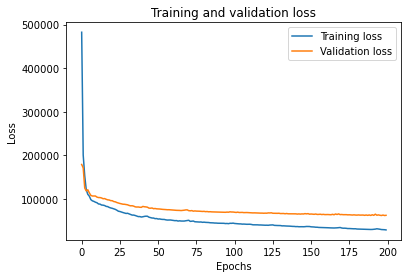

In [23]:
# plot loss history
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))

plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and validation loss')
plt.legend(['Training loss', 'Validation loss'], loc='upper right');
plt.show()


In [24]:
score = vae_model.evaluate(X_test, X_test, verbose = 1)

In [25]:
print('Test Loss:', score)

Test Loss: 13826.114214819183


In [26]:
#mae_vector = get_error_term(X_pred, X_test)#, _rmse=False)

# Code to predict the anomalies based on the threshold


y_pred = vae_model.predict(X_test)
y_dist = np.linalg.norm(X_test - y_pred, axis = -1)
threshold = np.quantile(y_dist, 0.75)
#threshold = 37.5

z = zip(y_dist >= threshold, y_dist)
y_label=[]
error = []
for idx, (is_anomaly, y_dist) in enumerate(z):
    if is_anomaly:
        y_label.append(1)
    else:
        y_label.append(0)
    error.append(y_dist)

C:\Users\Innocent SADO\Anaconda3\envs\Master2\lib\site-packages\keras\engine\training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [27]:
threshold

21.002866280061717

In [28]:
#Code to calculate AUC
from sklearn.metrics import confusion_matrix, roc_auc_score

roc_auc_score(y_test, y_label)

0.925531914893617

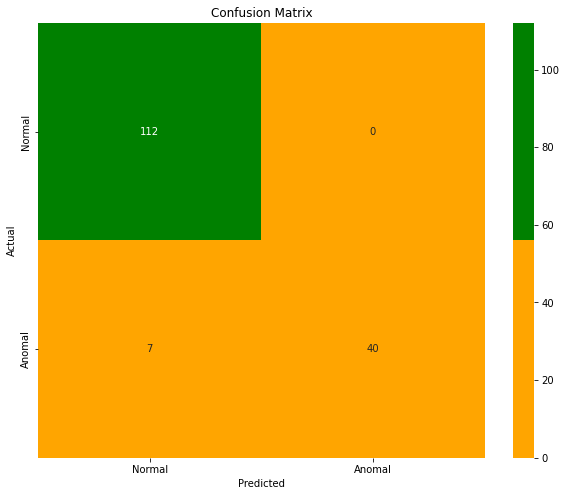

In [29]:
# Code to show the confusion matrix

viz = Visualization()
viz.draw_confusion_matrix(y_test, y_label)

In [30]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_label))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97       112
           1       1.00      0.85      0.92        47

    accuracy                           0.96       159
   macro avg       0.97      0.93      0.94       159
weighted avg       0.96      0.96      0.95       159



In [31]:
from sklearn import metrics

#y_pred =  (mae_vector > error_thresh).astype('int').ravel()
y_pred =  y_label
AUC = metrics.roc_auc_score(y_test, y_pred)
F1 = metrics.f1_score(y_test, y_pred)
Accuracy = metrics.accuracy_score(y_test, y_pred)
Precision = metrics.precision_score(y_test, y_pred)
Recall = metrics.recall_score(y_test, y_pred)
tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()
Specificity = tn / (tn+fp)

print("AUC: {:.2%}\n".format(AUC))
print("F1_score: {:.2%}\n".format(F1))
print("Accuracy: {:.2%}\n".format(Accuracy))
print("Precision: {:.2%}\n".format(Precision))
print("Recall: {:.2%}\n".format(Recall))
print("Specificity: {:.2%}\n".format(Specificity))

AUC: 92.55%

F1_score: 91.95%

Accuracy: 95.60%

Precision: 100.00%

Recall: 85.11%

Specificity: 100.00%

